In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf



In [2]:
df = pd.read_csv('../seir/cov_datasets/pcr_positive_daily_Sep18.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(df.shape)
print(df.dtypes)
df.head()

(611, 2)
Date        datetime64[ns]
Infected           float64
dtype: object


,Date,Infected
0,2020-01-16,1.0
1,2020-01-17,0.0
2,2020-01-18,0.0
3,2020-01-19,0.0
4,2020-01-20,0.0


In [3]:
training_set = df['Infected'][:500].values.astype(int)
test_set = df['Infected'][500:].values.astype(int)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set.reshape(len(training_set), 1))
testing_set_scaled = sc.fit_transform(test_set.reshape(len(test_set), 1))


# Creating a data structure with 5 time-steps and 2 output
X_train = []
y_train = []

X_test = []
y_test = []


In [4]:
print(training_set_scaled.shape)
print(testing_set_scaled.shape)

(500, 1)
(111, 1)


In [5]:
611-594

17

In [6]:
def split_seq(sequence, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(len(sequence)):
        end_idx = i + n_steps_in
        steps_out_idx = end_idx + n_steps_out
        
        #check if we reach end of arr or not
        if (steps_out_idx > len(sequence)):
            break
        seq_x = sequence[i:end_idx]
        seq_y = sequence[end_idx:steps_out_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
n_steps_in = 14
n_steps_out = 4

X_train , y_train = split_seq(training_set_scaled, n_steps_in, n_steps_out)
X_test , y_test = split_seq(testing_set_scaled, n_steps_in, n_steps_out)

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(483, 14, 1) (483, 4, 1)
(94, 14, 1) (94, 4, 1)


In [9]:
input_shape = (X_train.shape[1],X_train.shape[2])
input_shape

(14, 1)

In [21]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = n_steps_out))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 500, batch_size = 32, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/500
16/16 [==============================] - 2s 154ms/step - loss: 0.0455 - val_loss: 0.0684
Epoch 2/500
16/16 [==============================] - 0s 19ms/step - loss: 0.0458 - val_loss: 0.0532
Epoch 3/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0225 - val_loss: 0.0586
Epoch 4/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0327 - val_loss: 0.0635
Epoch 5/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0160 - val_loss: 0.0449
Epoch 6/500
16/16 [==============================] - 0s 21ms/step - loss: 0.0183 - val_loss: 0.0484
Epoch 7/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0132 - val_loss: 0.0447
Epoch 8/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0141 - val_loss: 0.0443
Epoch 9/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0137 - val_loss: 0.0439
Epoch 10/500
16/16 [==============================] - 0s 20ms/step - loss: 0.0144 - val_loss: 0.042

In [22]:
y_pred = model.predict(X_test)
y_pred = sc.inverse_transform(y_pred) #revert scaling

In [23]:
y_pred.shape

(94, 4)

In [24]:
#y_pred

In [25]:
y_test.shape

(94, 4, 1)

In [26]:
y_test_reshape = sc.inverse_transform(y_test.reshape(len(y_test), 4))
#y_test_reshape

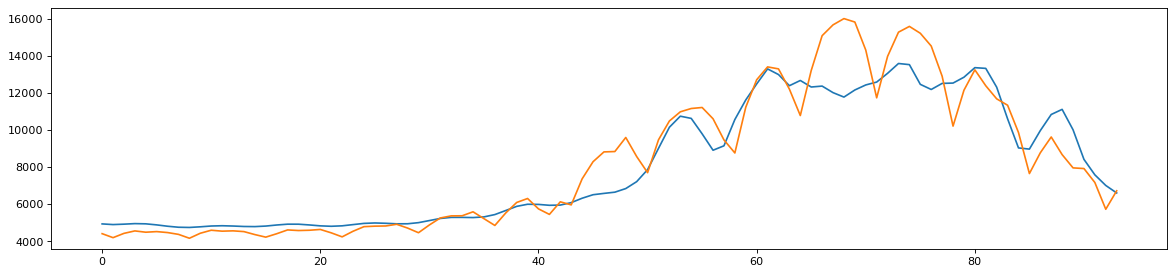

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(18, 4), dpi=80)

plt.plot(y_pred[:,0])
plt.plot(y_test_reshape[:,0])

In [28]:
mean_squared_error(y_test_reshape, y_pred)

1613501.3566401848

In [36]:
df[-14:]

,Date,Infected
597,2021-09-04,15997.0
598,2021-09-05,12890.0
599,2021-09-06,8223.0
600,2021-09-07,10586.0
601,2021-09-08,12384.0
602,2021-09-09,10378.0
603,2021-09-10,8869.0
604,2021-09-11,8793.0
605,2021-09-12,7204.0
606,2021-09-13,4161.0


### Rescaling input before feeding to model

In [29]:
x_input = np.array(df['Infected'][-14:]) # the lastest 14 days
x_input = sc.fit_transform(x_input.reshape(len(x_input), 1))
x_input = x_input.reshape((1, n_steps_in, 1))
print(x_input.shape)

(1, 14, 1)


In [30]:
y_pred2 = model.predict(x_input)
y_pred2 = sc.inverse_transform(y_pred2) #revert scaling

In [33]:
y_pred2.shape

(1, 4)

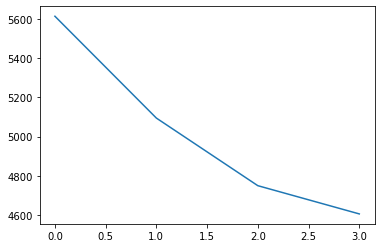

In [34]:
plt.plot(y_pred2[0,:])